In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

tensor(5)


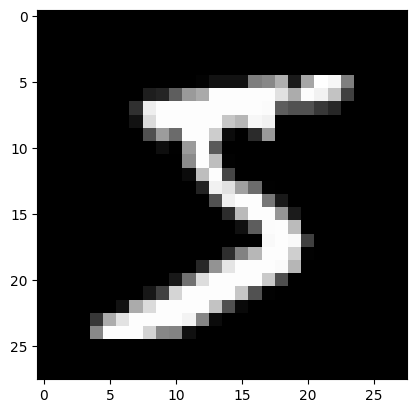

In [8]:
train_data, test_data = datasets.MNIST('data', train=True, download=True), datasets.MNIST('data', train=False, download=True)
x_train = train_data.data.view(-1, 28*28).float() / 255.0
y_train = train_data.targets
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [50]:
import torch.nn as nn
import torch.nn.functional as F

# Define the model as a subclass of nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.param_rows = nn.ParameterList([nn.Parameter(torch.randn(num_classes)) for i in range(input_dim)])
    
    def param_matrix(self):
        return torch.stack(list(self.param_rows), dim=0)
    
    def freeze_weights(self, i_unfrozen):
        for i, param in enumerate(self.param_rows):
            # print(i, i_unfrozen)
            param.requires_grad = (i == i_unfrozen)

    def generate_coordinate(self):
        return torch.randint(0, len(self.param_rows), (1,)).item()
    
    def forward(self, x):
        return x @ self.param_matrix()
    
def F_alpha_loss(model, x, target, alpha):
    logits = model(x) # (batch_size, num_classes)
    # we substract max_logits from exponential 
    # and then add them back for numerical stability
    max_logits = logits.max(dim=1, keepdim=True).values
    log_sum_exp = max_logits + (logits - max_logits).exp().sum(dim=1, keepdim=True).log() # (batch_size, 1)

    labels = target.unsqueeze(1) # (batch_size, 1)
    y_train = torch.zeros_like(logits).scatter(1, labels, 1) # (batch_size, num_classes)
    subtract_term = (y_train * logits).sum(dim=1, keepdim=True) # (batch_size, 1)

    loss_data = torch.mean(log_sum_exp - subtract_term) # scalar

    alpha_term = 0.5 * alpha * torch.sum(model.param_matrix() ** 2)

    return loss_data + alpha_term

In [51]:
def test(model, val_loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            predictions = logits.argmax(dim=1)
            total += y_batch.size(0)
            correct += (predictions == y_batch).sum().item()

    return correct / total

In [57]:
from tqdm import tqdm

def train(model, train_loader, 
          val_loader,
          alpha, optimizer, optimizer_params,
          num_epochs=10, patience=3):
    model.to(device)
    model.train()
    opt = optimizer(model.parameters(), **optimizer_params)
    epoch_losses = []
    
    best_accuracy = 0
    epochs_without_improvement = 0

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            opt.zero_grad()
            coordinate = model.generate_coordinate()
            model.freeze_weights(coordinate)
            loss = F_alpha_loss(model, x_batch, y_batch, alpha)
            loss.backward()
            opt.step(coord_list=[coordinate])
            running_loss += loss.item()
        
        avg_epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        
        accuracy = test(model, val_loader)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    plt.plot(epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss for alpha = {}'.format(alpha))
    plt.show()

    return model

In [58]:
from torch.utils.data import DataLoader, TensorDataset

def solve_bilevel(alpha_range,
                  train_data,
                  val_loader,
                  optimizer,
                  optimizer_params,
                  num_epochs=10,
                  batch_size=64):
    best_alpha = None
    best_acc = 0
    best_model = None

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    input_dim = train_data.tensors[0].shape[1]
    num_classes = len(np.unique(train_data.tensors[1].numpy()))

    for alpha in alpha_range:
        print(f'Alpha: {alpha}')
        model = LogisticRegression(input_dim, num_classes)
        model = train(model, train_loader, val_loader, alpha, optimizer, optimizer_params, num_epochs)
        acc = test(model, val_loader)
        print(f'Accuracy: {acc}')

        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
            best_model = model

    print(f'Best alpha: {best_alpha}, Best accuracy: {best_acc}')
    return best_alpha, best_acc, best_model

In [59]:
from torch.optim import Optimizer

class CoordinateDescent(Optimizer):
    def __init__(self, params, lr=0.1):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr)
        super(CoordinateDescent, self).__init__(params, defaults)

    def step(self, closure=None, coord_list=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group, coord in zip(self.param_groups, coord_list):
            p = group['params'][coord]
            if p.grad is None:
                continue
            d_p = p.grad
            p.data.add_(-group['lr'], d_p)
        return loss

In [72]:
# CONSTANTS
dimension = x_train.shape[1]
ALPHA_RANGE = [0.00001, 0.0001, 0.001, 0.01, 0.1]
NUM_EPOCHS = 1000
OPTIMIZER_PARAMS = {'lr': 0.01 * dimension}
BATCH_SIZE = 256
TRAIN_VAL_SPLIT_RATIO = 0.8
OPTIMIZER = CoordinateDescent

Alpha: 1e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

 11%|█         | 109/1000 [01:20<11:01,  1.35it/s]

Early stopping triggered at epoch 110


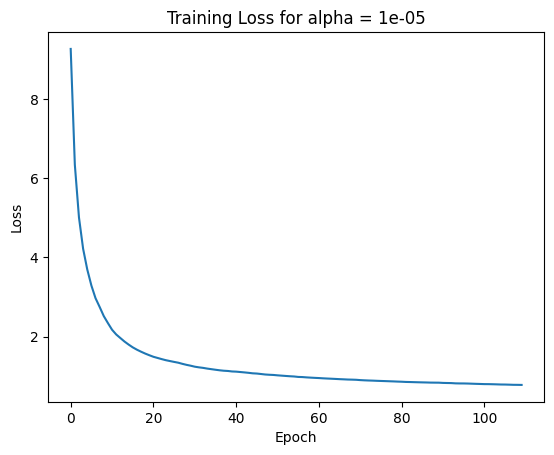

Accuracy: 0.8468333333333333
Alpha: 0.0001


  9%|▉         | 89/1000 [01:05<11:07,  1.36it/s]

Early stopping triggered at epoch 90


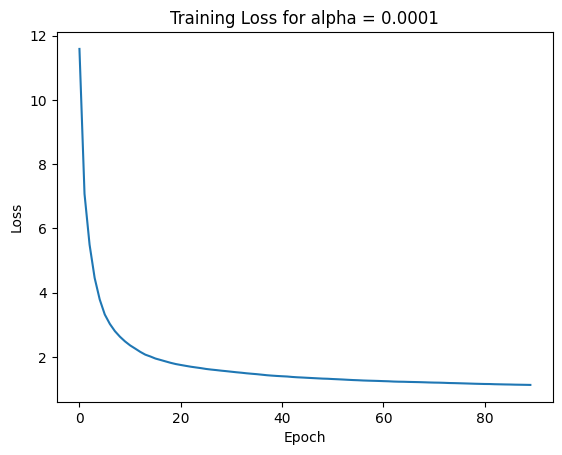

Accuracy: 0.83775
Alpha: 0.001


  8%|▊         | 82/1000 [01:00<11:18,  1.35it/s]

Early stopping triggered at epoch 83


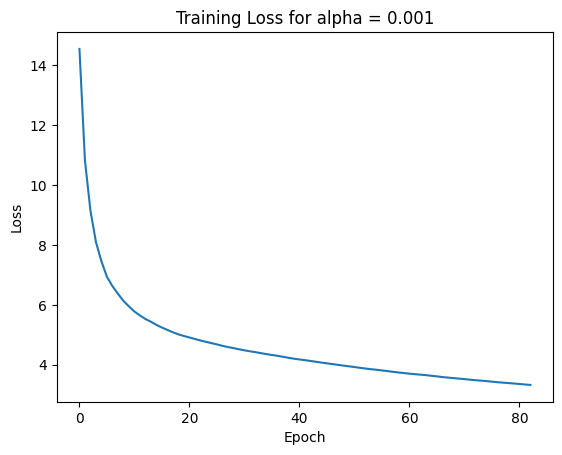

Accuracy: 0.8438333333333333
Alpha: 0.01


  7%|▋         | 74/1000 [00:54<11:20,  1.36it/s]

Early stopping triggered at epoch 75


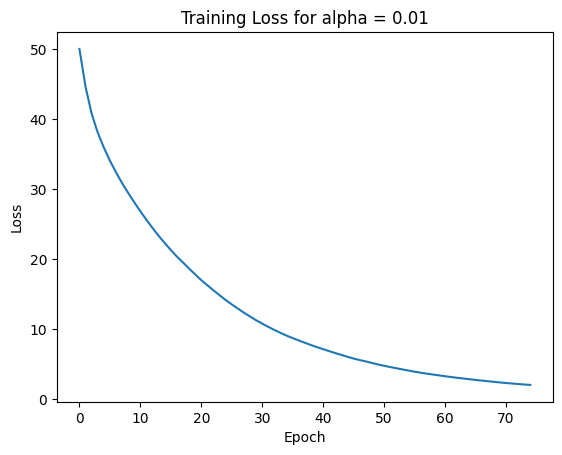

Accuracy: 0.8705
Alpha: 0.1


  3%|▎         | 33/1000 [00:25<12:12,  1.32it/s]

Early stopping triggered at epoch 34


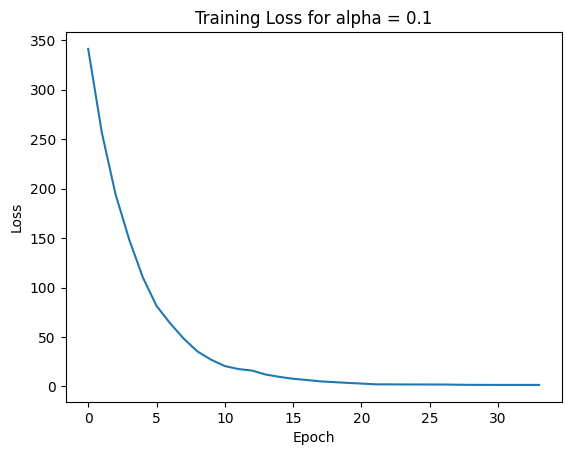

Accuracy: 0.8306666666666667
Best alpha: 0.01, Best accuracy: 0.8705


In [73]:


train_data = TensorDataset(x_train, y_train)
train_size = int(TRAIN_VAL_SPLIT_RATIO * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])
# make train data dataset again
train_data = TensorDataset(train_data.dataset.tensors[0], train_data.dataset.tensors[1])

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

best_alpha, best_acc, best_model = solve_bilevel(ALPHA_RANGE, train_data, val_loader, OPTIMIZER, OPTIMIZER_PARAMS, NUM_EPOCHS, BATCH_SIZE)

In [74]:
# Test the best model
x_test = test_data.data.view(-1, 28*28).float() / 255.0
y_test = test_data.targets
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_acc = test(best_model, test_loader)
print(f'Test accuracy: {test_acc}')

Test accuracy: 0.8774
